# Propagation of the selected cases using SWAN

The cases are already selected and now, these selected cases must be propagated to shallow water so the wave climate can be reconstructed in the desired coast.

The propagation of the cases is not performed equally for the windeas and the swells, as it was described in the MDA notebook. When the windseas are propagated, wind is taken into account and the parameter $\gamma$ (named as _jonswap_gamma_ or _ws.gamma_ in the code) takes a constant value of 3. On the other hand, swells are propagated without the effect of the local wind, and its shape parameter $\gamma$ depends on each individual case. For this purpose, the only thing that must be done so the propagations can run correctly is change the <code>make_input</code> function in the <code>io.py</code> file as it is shown below:

![io.py](../images/swan/io-file-examples.png)

Notice that the <code>io.py</code> file is loaded as a module, so once the seas have been run, the kernel must be restarted, and all the modules must be reloaded again. Run the seas by running all the cells below until the <b>advice</b> cell in blue appears, and then repeat the process for the swells, changing the <code>io.py</code> file first.

A very important fact in this propagation section is the computational effort that is made, and which is translated into time. The software that is used here is proportioned by the [Technical Univerity of Delft](https://www.tudelft.nl/) and is called [SWAN](http://swanmodel.sourceforge.net/) (Simulating WAves Nearshore). With SWAN, each individual case is propagated dinamically to each cell or point in the bathymetry grid, resolving phenomenons such as diffraction and refraction. This is very expensive at the computational level, so just a certain number of cases are propagated that will be used later to reconstruct the total historical dataset.

<font color=red>Time wasted running the cases: </font> The time depends on the number of cases that wanna be run and the shape of the bathymetry or region desired, as it is obvious, but as a reference, __100 windseas__ cases can take a time of about __3 hours__ while __100 swells__ can be resolved in __1 hour__, a third of the time.

## Windseas can be run below

\begin{equation*}
\textit{Windseas: } \:\: H_S \:\: T_P \:\: \theta_m \:\: \sigma_\theta \:\: W \:\: \theta_W
\end{equation*}

In [1]:
# common 
import sys
import os
import os.path as op

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

from time import time

import warnings
warnings.filterwarnings("ignore")

t0 = time()

# swan wrap module
from lib.wrap import SwanProject, SwanWrap_STAT

In [2]:
# data
p_data = op.abspath(op.join(os.getcwd(), '..', 'data'))
p_hind = op.join(p_data, 'hindcast')
waves = pd.read_pickle(op.join(p_hind, 'sea_cases_300.pkl'))[::50]

waves.rename(columns={'Hsea'   : 'hs',
                      'Tpsea'  : 'per',
                      'Dirsea' : 'dir',
                      'Sprsea' : 'spr',
                      'W'      : 'vel',
                      'DirW'   : 'dirw'}, inplace=True)

print(waves.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 250
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hs      6 non-null      float64
 1   per     6 non-null      float64
 2   dir     6 non-null      float64
 3   spr     6 non-null      float64
 4   vel     6 non-null      float64
 5   dirw    6 non-null      float64
dtypes: float64(6)
memory usage: 416.0 bytes
None


### <font color=red>EDIT SECTION BELOW:</font>

Here, the grid where the bathymetry will be run is selected. Notice that the file used for this bathymetry is not the global file proportioned by GEBCO, but a regional file that can be also downloaded from the application in this [website](https://www.gebco.net/). An example of the aspect of this application in the region selected in this notebook is shown below:

![GEBCO](../images/swan/gebco-example.png)

As a recommendation, download a bigger area than the one that wants to be used, as the file size will not be much larger, but it is better to ensure the area you are selecting is valid.

In [3]:
# --------------------------------------------------------------------------- #
# GRID PARAMETERS
# --------------------------------------------------------------------------- #
# ----------------  EDIT ONLY THIS PART  ------------------------------------ #
# --------------------------------------------------------------------------- #
name = 'SAF' # please choose a short name (max 3 letters)
# Coordinates section
# Place the coordinates as they are proportioned in Google Maps
ini_lon = 24.74
end_lon = 25.02
ini_lat = -34.26
end_lat = -33.95
# --------------------------------------------------------------------------- #
# ----------------  END EDIT  ----------------------------------------------- #

In [4]:
# --------------------------------------------------------------------------- #
# depth auto-selection
p_depth = op.join(p_data, 'bathymetry', 'gebco_2020_n-33.0_s-35.0_w24.0_e26.0.nc')
depth = xr.open_dataset(p_depth)
depth = depth.sel(lat=slice(ini_lat,end_lat)).sel(lon=slice(ini_lon,end_lon))
x_point = len(depth.lon.values)
y_point = len(depth.lat.values)
resolution = round(abs(end_lon - ini_lon) / x_point, 4)

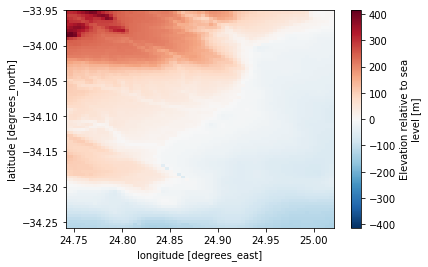

In [5]:
depth.elevation.plot()

The bathymetry will have the shape: 

Points in the longitude axis: 67
Points in the latitude axis: 74


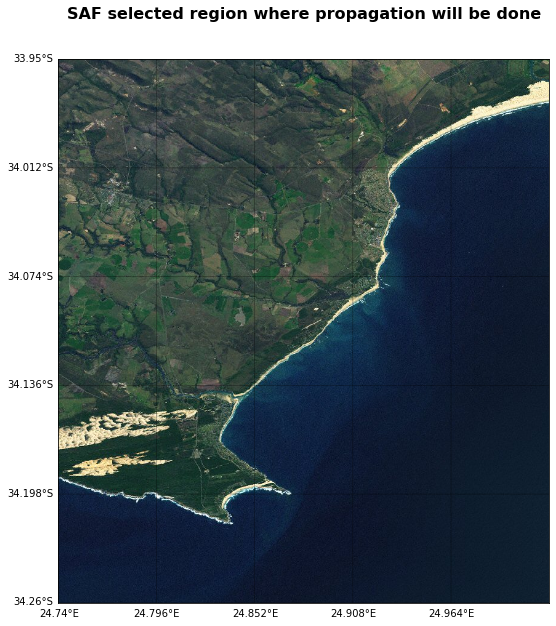

In [13]:
# Figure intialization
plt.figure(figsize=(10,10))
plt.title(name + ' selected region where propagation will be done',
          fontsize=16, fontweight='bold', pad=40)

# Plot the Basemap
m = Basemap(llcrnrlon=ini_lon,  llcrnrlat=ini_lat, 
            urcrnrlon=end_lon, urcrnrlat=end_lat, 
            resolution='l')
 
# Then add element: draw coast line, map boundary, and fill continents:
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=1000) # becareful with adding xpixels
grid_step_lon = round(abs(end_lon - ini_lon) / 5, 3)
grid_step_lat = round(abs(end_lat - ini_lat) / 5, 3)
m.drawmeridians(np.arange(ini_lon, end_lon+grid_step_lon, grid_step_lon), 
                linewidth=0.5, labels=[1,0,0,1])
m.drawparallels(np.arange(ini_lat, end_lat+grid_step_lat, grid_step_lat), 
                linewidth=0.5, labels=[1,0,0,1])

print('The bathymetry will have the shape: \n')
print('Points in the longitude axis: ' + str(x_point))
print('Points in the latitude axis: ' + str(y_point))

### <font color=red>RUN THE WINDSEAS IN THE CELL BELOW</font>

In [6]:
# --------------------------------------------------------------------------- #
# SWAN project 
p_proj = op.join(p_data, 'projects-swan')    # swan projects main directory
n_proj = name + '-SEA-' + str(resolution)    # project name

sp = SwanProject(p_proj, n_proj)

# depth grid description (input bathymetry grid)
sp.mesh_main.dg = {
    'xpc': ini_lon,            # x origin
    'ypc': ini_lat,            # y origin
    'alpc': 0,                 # x-axis direction 
    'xlenc': end_lon-ini_lon,  # grid length in x
    'ylenc': end_lat-ini_lat,  # grid length in y
    'mxc': x_point-1,          # number mesh x
    'myc': y_point-1,          # number mesh y
    'dxinp': resolution,       # size mesh x
    'dyinp': resolution,       # size mesh y
}

# depth swan init
sp.mesh_main.depth = - depth.elevation.values

# computational grid description
sp.mesh_main.cg = {
    'xpc': ini_lon,
    'ypc': ini_lat,
    'alpc': 0,
    'xlenc': end_lon-ini_lon,
    'ylenc': end_lat-ini_lat,
    'mxc': x_point,
    'myc': y_point,
    'dxinp': resolution,
    'dyinp': resolution,
}

# SWAN parameters (sea level, jonswap gamma)
sp.params = {
    'sea_level': 0,
    'jonswap_gamma': 3,
    'cdcap': None,
    'coords_spherical': None,
    'waves_period': 'PEAK',
    'maxerr': None,
}

# SWAN wrap STAT (create case files, launch SWAN num. model, extract output)
sw = SwanWrap_STAT(sp)

# build stationary cases from waves data
sw.build_cases(waves)

# run SWAN
sw.run_cases()

# extract output from main mesh 
waves_propagated = sw.extract_output()

# save to netCDF file and cases propagated to dataframe
waves.to_pickle(op.join(p_proj, n_proj, 'sea_cases_300.pkl'))
waves_propagated.to_netcdf(op.join(p_proj, n_proj, 
                           'sea_propagated_300.nc'))

print('Time transcurred: ' + str(round((time()-t0)/3600, 2)) + ' h')

SWAN CASE: 0000 ---> hs   13.36, per   15.88, dir  293.00, spr   24.10
SWAN CASE: 0001 ---> hs    0.31, per    4.69, dir  335.00, spr   17.50
SWAN CASE: 0002 ---> hs    4.18, per   10.67, dir  298.00, spr   24.70
SWAN CASE: 0003 ---> hs    0.07, per    2.60, dir  103.00, spr   15.00
SWAN CASE: 0004 ---> hs    0.92, per    3.88, dir   73.00, spr   29.30
SWAN CASE: 0005 ---> hs    0.43, per    3.41, dir  255.00, spr   62.10
SWAN CASE: 0000 SOLVED
SWAN CASE: 0001 SOLVED
SWAN CASE: 0002 SOLVED
SWAN CASE: 0003 SOLVED
SWAN CASE: 0004 SOLVED
SWAN CASE: 0005 SOLVED
Time transcurred: 0.07 h


In [ ]:
# Select the case to plot
case = 2

Text(0.04, 0.88, ' $H_S$ = 4.18 m\n $T_P$ = 10.67 s\n $\\theta _{m}$ = 298.00 $\\degree$\n $\\sigma _\\theta$ = 24.70 $\\degree$\n $W$ = 9.53 m/s\n $\\theta _{W}$ = 265.19 $\\degree$')

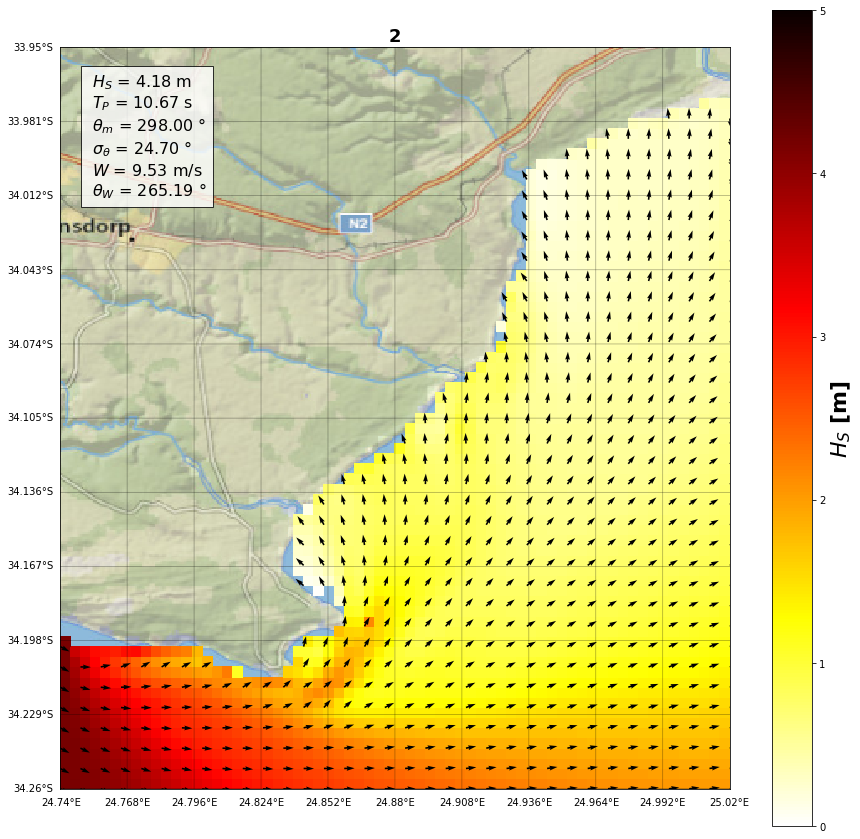

In [12]:
plt.figure(figsize=(15,15))

# Plot the Basemap
m = Basemap(llcrnrlon=ini_lon,  llcrnrlat=ini_lat, 
            urcrnrlon=end_lon, urcrnrlat=end_lat, 
            resolution='l')
 
# Then add element: draw coast line, map boundary, and fill continents:
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=1000) # becareful with adding xpixels
grid_step_lon = round(abs(end_lon - ini_lon) / 10, 3)
grid_step_lat = round(abs(end_lat - ini_lat) / 10, 3)
m.drawmeridians(np.arange(ini_lon, end_lon+grid_step_lon, grid_step_lon), 
                linewidth=0.5, labels=[1,0,0,1])
m.drawparallels(np.arange(ini_lat, end_lat+grid_step_lat, grid_step_lat), 
                linewidth=0.5, labels=[1,0,0,1])

waves_case = waves.iloc[case]
plt.title(str(case), fontsize=18, fontweight='bold')
# --------------------------------------------------------------------------- #
# Hsig
xx = np.linspace(ini_lon, end_lon, x_point)
yy = np.linspace(ini_lat, end_lat, y_point)
X, Y = np.meshgrid(xx, yy)
hsig = waves_propagated.sel(case=case).Hsig.values.T
P = plt.pcolor(X, Y, hsig, cmap='hot_r', vmin=0, vmax=5)
PC = plt.colorbar(P)
PC.set_label('$H_{S}$ [m]', fontsize=22, fontweight='bold')
# --------------------------------------------------------------------------- #
# Dir, Dspr and Tp
dir_step = 2 # not all arrows are plotted
xx = xx[::dir_step]
yy = yy[::dir_step]
X, Y = np.meshgrid(xx, yy)
dirr = waves_propagated.sel(case=case).Dir.values.T
dirr = (dirr*np.pi/180)[::dir_step,::dir_step]
perr = waves_propagated.sel(case=case).TPsmoo.values.T
perr = perr[::dir_step,::dir_step]
U = -(np.sin(dirr) * perr)
V = -(np.cos(dirr) * perr)
plt.quiver(X, Y, U, V, color='k')
plt.xticks([])
plt.yticks([])

textstr = '\n'.join((
        r' $H_S$ = %.2f m' % (waves_case['hs'], ),
        r' $T_P$ = %.2f s' % (waves_case['per'], ),
        r' $\theta _{m}$ = %.2f $\degree$' % (waves_case['dir'], ),
        r' $\sigma _\theta$ = %.2f $\degree$' % (waves_case['spr'], ),
        r' $W$ = %.2f m/s' % (waves_case['vel'], ),
        r' $\theta _{W}$ = %.2f $\degree$' % (waves_case['dirw'], )))
plt.text(0.04, 0.88, textstr, 
         {'color': 'k', 'fontsize': 16},
         horizontalalignment='left',
         verticalalignment='center',
         transform=plt.gca().transAxes,
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 6})

<div class="alert alert-block alert-info">
<b>Advice:</b> Restart the kernel now so the changed files (<code>make_input</code> function) can be reloaded correctly and the propagations of the swells can work.
</div>

## Swells can be run below

\begin{equation*}
\textit{Swells: } \:\: H_S \:\: T_P \:\: \theta_m \:\: \sigma_\theta \:\: \gamma
\end{equation*}

In [3]:
# common 
import sys
import os
import os.path as op

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

from time import time

import warnings
warnings.filterwarnings("ignore")

t0 = time()

# swan wrap module
from lib.wrap import SwanProject, SwanWrap_STAT

In [4]:
# --------------------------------------------------------------------------- #
# data
p_data = op.abspath(op.join(os.getcwd(), '..', 'data'))
p_hind = op.join(p_data, 'hindcast')
waves = pd.read_pickle(op.join(p_hind, 'swell_cases_300.pkl'))[::50]

waves.rename(columns={'Hswell'   : 'hs',
                      'Tpswell'  : 'per',
                      'Dirswell' : 'dir',
                      'Sprswell' : 'spr',
                      'Gamma'    : 'gamma'}, inplace=True)

print(waves.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 250
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hs      6 non-null      float64
 1   per     6 non-null      float64
 2   dir     6 non-null      float64
 3   spr     6 non-null      float64
 4   gamma   6 non-null      float64
dtypes: float64(5)
memory usage: 368.0 bytes
None


In [5]:
# --------------------------------------------------------------------------- #
# GRID PARAMETERS
# --------------------------------------------------------------------------- #
# ----------------  EDIT ONLY THIS PART  ------------------------------------ #
# --------------------------------------------------------------------------- #
name = 'SAF' # please choose a short name (max 3 letters)
# Coordinates section
# Place the coordinates as they are proportioned in Google Maps
ini_lon = 24.74
end_lon = 25.02
ini_lat = -34.26
end_lat = -33.95
# --------------------------------------------------------------------------- #
# ----------------  END EDIT  ----------------------------------------------- #

In [6]:
# --------------------------------------------------------------------------- #
# depth auto-selection
p_depth = op.join(p_data, 'bathymetry', 'GEBCO_2020.nc')
depth = xr.open_dataset(p_depth)
depth = depth.sel(lat=slice(ini_lat,end_lat)).sel(lon=slice(ini_lon,end_lon))
x_point = len(depth.lon.values)
y_point = len(depth.lat.values)
resolution = round(abs(end_lon - ini_lon) / x_point, 4)

### <font color=red>RUN THE SWELLS IN THE CELL BELOW</font>

In [7]:
# --------------------------------------------------------------------------- #
# SWAN project 
p_proj = op.join(p_data, 'projects-swan')    # swan projects main directory
n_proj = name + '-SWELL-' + str(resolution)  # project name

sp = SwanProject(p_proj, n_proj)

# depth grid description (input bathymetry grid)
sp.mesh_main.dg = {
    'xpc': ini_lon,            # x origin
    'ypc': ini_lat,            # y origin
    'alpc': 0,                 # x-axis direction 
    'xlenc': end_lon-ini_lon,  # grid length in x
    'ylenc': end_lat-ini_lat,  # grid length in y
    'mxc': x_point-1,          # number mesh x
    'myc': y_point-1,          # number mesh y
    'dxinp': resolution,       # size mesh x
    'dyinp': resolution,       # size mesh y
}

# depth swan init
sp.mesh_main.depth = - depth.elevation.values

# computational grid description
sp.mesh_main.cg = {
    'xpc': ini_lon,
    'ypc': ini_lat,
    'alpc': 0,
    'xlenc': end_lon-ini_lon,
    'ylenc': end_lat-ini_lat,
    'mxc': x_point,
    'myc': y_point,
    'dxinp': resolution,
    'dyinp': resolution,
}

# SWAN parameters (sea level, jonswap gamma)
sp.params = {
    'sea_level': 0,
    'cdcap': None,
    'coords_spherical': None,
    'waves_period': 'PEAK',
    'maxerr': None,
}

# SWAN wrap STAT (create case files, launch SWAN num. model, extract output)
sw = SwanWrap_STAT(sp)

# build stationary cases from waves data
sw.build_cases(waves)

# run SWAN
sw.run_cases()

# extract output from main mesh 
waves_propagated = sw.extract_output()

# save to netCDF file and cases propagated to dataframe
waves.to_pickle(op.join(p_proj, n_proj, 'swell_cases_300.pkl'))
waves_propagated.to_netcdf(op.join(p_proj, n_proj, 
                           'swell_propagated_300.nc'))

print('Time transcurred: ' + str(round((time()-t0)/3600, 2)) + ' h')

SWAN CASE: 0000 ---> hs   10.90, per   18.27, dir  290.00, spr   20.60
SWAN CASE: 0001 ---> hs    1.24, per    5.94, dir  304.00, spr   34.70
SWAN CASE: 0002 ---> hs    1.36, per   10.86, dir  329.00, spr   27.90
SWAN CASE: 0003 ---> hs    0.44, per    4.47, dir  118.00, spr   35.20
SWAN CASE: 0004 ---> hs    0.82, per    4.80, dir  102.00, spr   45.60
SWAN CASE: 0005 ---> hs    2.34, per    8.08, dir   57.00, spr   31.60
SWAN CASE: 0000 SOLVED
SWAN CASE: 0001 SOLVED
SWAN CASE: 0002 SOLVED
SWAN CASE: 0003 SOLVED
SWAN CASE: 0004 SOLVED
SWAN CASE: 0005 SOLVED
Time transcurred: 0.05 h


In [ ]:
# Select the case to plot
case = 5

Text(0.04, 0.88, ' $H_S$ = 2.34 m\n $T_P$ = 8.08 s\n $\\theta _{m}$ = 57.00 $\\degree$\n $\\sigma _\\theta$ = 31.60 $\\degree$\n $\\gamma$ = 1.00')

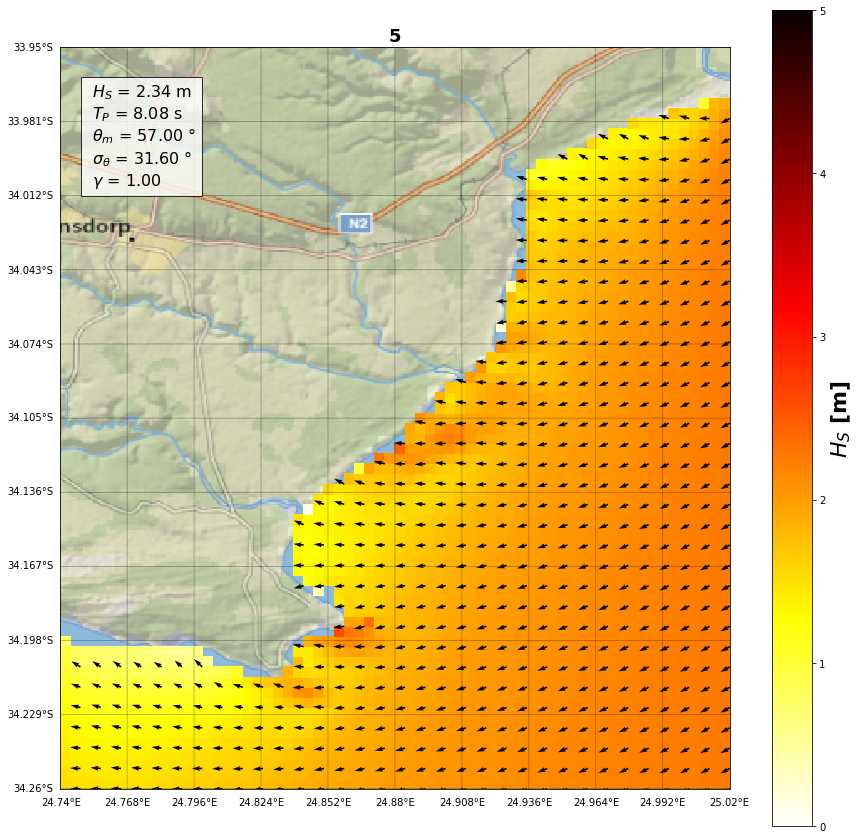

In [12]:
plt.figure(figsize=(15,15))

# Plot the Basemap
m = Basemap(llcrnrlon=ini_lon,  llcrnrlat=ini_lat, urcrnrlon=end_lon, urcrnrlat=end_lat, 
            resolution='l')
 
# Then add element: draw coast line, map boundary, and fill continents:
m.arcgisimage(service='NatGeo_World_Map')
grid_step_lon = round(abs(end_lon - ini_lon) / 10, 3)
grid_step_lat = round(abs(end_lat - ini_lat) / 10, 3)
m.drawmeridians(np.arange(ini_lon, end_lon+grid_step_lon, grid_step_lon), 
                linewidth=0.5, labels=[1,0,0,1])
m.drawparallels(np.arange(ini_lat, end_lat+grid_step_lat, grid_step_lat), 
                linewidth=0.5, labels=[1,0,0,1])

waves_case = waves.iloc[case]
plt.title(str(case), fontsize=18, fontweight='bold')
# --------------------------------------------------------------------------- #
# Hsig
xx = np.linspace(ini_lon, end_lon, x_point)
yy = np.linspace(ini_lat, end_lat, y_point)
X, Y = np.meshgrid(xx, yy)
hsig = waves_propagated.sel(case=case).Hsig.values.T
P = plt.pcolor(X, Y, hsig, cmap='hot_r', vmin=0, vmax=5)
PC = plt.colorbar(P)
PC.set_label('$H_{S}$ [m]', fontsize=22, fontweight='bold')
# --------------------------------------------------------------------------- #
# Dir, Dspr and Tp
dir_step = 2 # not all arrows are plotted
xx = xx[::dir_step]
yy = yy[::dir_step]
X, Y = np.meshgrid(xx, yy)
dirr = waves_propagated.sel(case=case).Dir.values.T
dirr = (dirr*np.pi/180)[::dir_step,::dir_step]
perr = waves_propagated.sel(case=case).TPsmoo.values.T
perr = perr[::dir_step,::dir_step]
U = -(np.sin(dirr) * perr)
V = -(np.cos(dirr) * perr)
plt.quiver(X, Y, U, V, color='k')
plt.xticks([])
plt.yticks([])

textstr = '\n'.join((
        r' $H_S$ = %.2f m' % (waves_case['hs'], ),
        r' $T_P$ = %.2f s' % (waves_case['per'], ),
        r' $\theta _{m}$ = %.2f $\degree$' % (waves_case['dir'], ),
        r' $\sigma _\theta$ = %.2f $\degree$' % (waves_case['spr'], ),
        r' $\gamma$ = %.2f' % (waves_case['gamma'], )))
plt.text(0.04, 0.88, textstr, 
         {'color': 'k', 'fontsize': 16},
         horizontalalignment='left',
         verticalalignment='center',
         transform=plt.gca().transAxes,
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 6})

If you have reached this cell without errors, then the cases have been run correctly and the saved data is stored in data/projects-swan. If an error has occured, you can also have a look at the _Error output file_ in the cases folders, and also the issues section is available in the repository for this purpose.

The propagated files will be used in the reconstruction step (RBF) so please be sure they have been correctly generated.